In [1]:
import torch
import numpy as np

In [2]:
# POTENTIAL
 # Muller-Brown potential
def compute_Muller_potential(scale, x):
    A = (-200.0, -100.0, -170.0, 15.0)
    beta = (0.0, 0.0, 11.0, 0.6)
    alpha_gamma = (
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-6.5, -6.5]),
        x.new_tensor([0.7, 0.7]),
    )
    ab = (
        x.new_tensor([1.0, 0.0]),
        x.new_tensor([0.0, 0.5]),
        x.new_tensor([-0.5, 1.5]),
        x.new_tensor([-1.0, 1.0]),
    )
    U = 0
    for i in range(4):
        diff = x - ab[i]
        U = U + A[i] * torch.exp(
            torch.sum(alpha_gamma[i] * diff**2, -1) + beta[i] * torch.prod(diff, -1)
        )
    U = scale * U
    return U

def compute_gradient(scale, x):
    # Function to compute the gradient of the Müller-Brown potential
    U = compute_Muller_potential(scale, x)
    grad_U = torch.autograd.grad(U, x, create_graph=True)[0]
    return grad_U



In [3]:

# GIBBS + REJECTION SAMPLING


def rejection_sampling(fixed_value, variable_range, scale, fixed_is_x, num_samples=10000):
    accepted_samples = []

    # Compute the distirbution points = [[fixed_value, variable_range[0]], [fixed_value, variable_range[1]] ... ]
    points = torch.zeros((len(variable_range), 2))
    if fixed_is_x:
        points[:, 0] = fixed_value
        points[:, 1] = torch.tensor(variable_range)
    else:
        points[:, 0] = torch.tensor(variable_range)
        points[:, 1] = fixed_value
    potentials = -compute_Muller_potential(scale, points)
    max_potential = torch.max(potentials)
    
    total_samples = 0
    while total_samples < num_samples:
        
        
        sample = np.random.uniform(variable_range[0], variable_range[-1])
        if fixed_is_x:
            point = torch.tensor([fixed_value, sample], dtype=torch.float32)
        else:
            point = torch.tensor([sample, fixed_value], dtype=torch.float32)

        potential = -compute_Muller_potential(scale, point)
        if np.log(np.random.uniform(0, 1)) <= potential - max_potential:
            accepted_samples.append(sample)
            total_samples += 1
            
    return accepted_samples


# Gibbs sampling function
def gibbs_sampling_Muller_potential(scale, num_samples, variable_range_x, variable_range_y):
    samples = np.zeros((num_samples, 2))
    
    for i in range(num_samples):
        # Initialize x and y
        x = np.random.uniform(variable_range_x[0], variable_range_x[-1])
        y = np.random.uniform(variable_range_y[0], variable_range_y[-1])
        
        # Sample x given y
        x = rejection_sampling(y, variable_range_x, scale, False, 1)[0]
        # Sample y given x
        y = rejection_sampling(x, variable_range_y, scale, True, 1)[0]

        samples[i] = [x, y]

    return samples


In [4]:
# METROPOLIS


# Defining the target PDF based on the Müller-Brown potential
def target_pdf_muller_brown(x, scale=1.0, temperature=1.0):
    potential = compute_Muller_potential(scale, x)
    return torch.exp(-potential / temperature)

# Proposal distribution function: Gaussian centered at the current parameter
def proposal_dist_gaussian(current_param, std_dev=0.1):
    proposed_param = current_param + torch.randn_like(current_param) * std_dev
    return proposed_param

# Metropolis-Hastings algorithm adapted for the Müller-Brown potential
def metropolis_hastings_muller_brown(target_pdf, proposal_dist, iterations, temperature=1.0, scale=1.0):
    initial_param = torch.randn(2)
    current_param = initial_param
    samples = [current_param.numpy()]
    
    for _ in range(iterations):
        proposed_param = proposal_dist(current_param)
        acceptance_probability = min(
            1,
            (target_pdf(proposed_param, scale, temperature) / target_pdf(current_param, scale, temperature)).item()
        )
        if torch.rand(1).item() < acceptance_probability:
            current_param = proposed_param
        samples.append(current_param.numpy())
    return np.array(samples)
    
def kl_divergence(p, q):
    # Adding a small constant for smoothing
    epsilon = 1e-10
    p_smoothed = p + epsilon
    q_smoothed = q + epsilon
    return np.sum(np.where(p_smoothed != 0, p_smoothed * np.log(p_smoothed / q_smoothed), 0))

def generate_grid(x1_min, x1_max, x2_min, x2_max, size=100):
    x1 = torch.linspace(x1_min, x1_max, size)
    x2 = torch.linspace(x2_min, x2_max, size)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="ij")
    grid = torch.stack([grid_x1, grid_x2], dim=-1)
    x = grid.reshape((-1, 2))
    return x

In [5]:
# Parameters
num_samples = 10000
grid_size = 100
scale = 0.05
x_min, x_max = -2.0, 1.0
y_min, y_max = -0.5, 2.0
temperature = 1.0
variable_range_x = np.linspace(x_min, x_max, grid_size)
variable_range_y = np.linspace(y_min, y_max, grid_size)
n_runs = 10

# Generate samples from both methods
# Perform Gibbs sampling with the Muller-Brown potential
gibbs_samples_all = []
metropolis_samples_all = []

gibbs_samples = gibbs_sampling_Muller_potential(scale, num_samples, variable_range_x, variable_range_y)
for i in range(n_runs):
    metropolis_samples = metropolis_hastings_muller_brown(target_pdf_muller_brown, proposal_dist_gaussian, num_samples, temperature, scale)
    
    gibbs_samples_all.append(gibbs_samples)
    metropolis_samples_all.append(metropolis_samples)

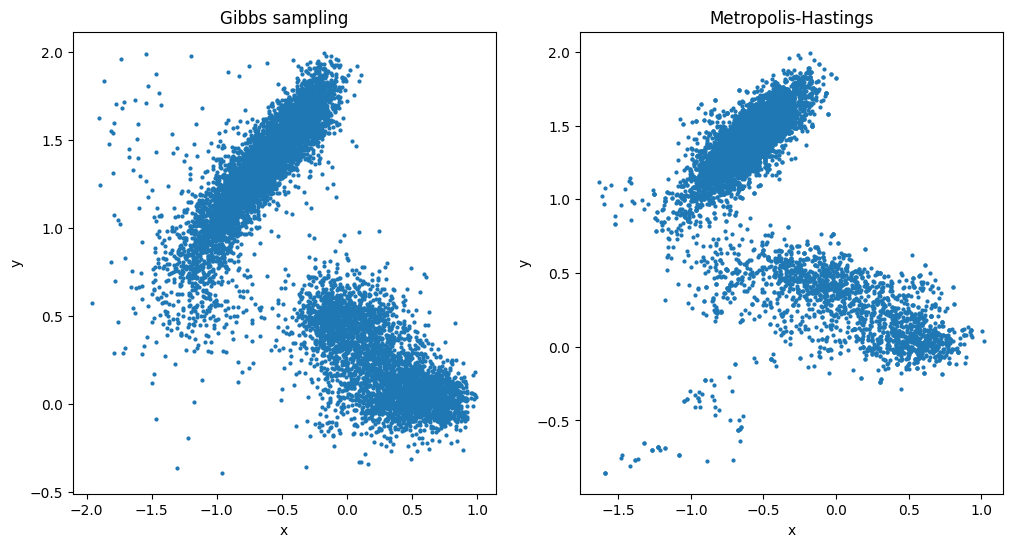

In [6]:
# Plot gibbs samples
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(gibbs_samples[:, 0], gibbs_samples[:, 1], "o", markersize=2)
plt.title("Gibbs sampling")
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
plt.plot(metropolis_samples[:, 0], metropolis_samples[:, 1], "o", markersize=2)
plt.title("Metropolis-Hastings")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


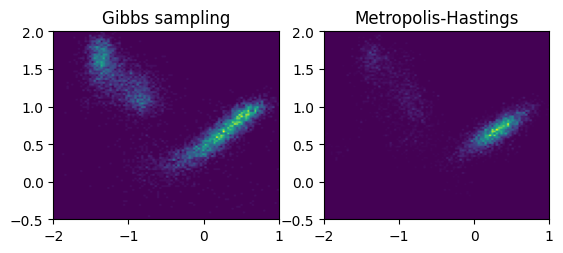

In [7]:
# Create 2D histograms for the samples
hist_gibbs, _, _ = np.histogram2d(gibbs_samples[:, 0], gibbs_samples[:, 1], bins=grid_size, range=[[x_min, x_max], [y_min, y_max]])
hist_metropolis, _, _ = np.histogram2d(metropolis_samples[:, 0], metropolis_samples[:, 1], bins=grid_size, range=[[x_min, x_max], [y_min, y_max]])
# Plot the histograms
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].imshow(hist_gibbs, origin="lower", extent=[x_min, x_max, y_min, y_max])
ax[0].set_title("Gibbs sampling")
ax[1].imshow(hist_metropolis, origin="lower", extent=[x_min, x_max, y_min, y_max])
ax[1].set_title("Metropolis-Hastings")
plt.show()


In [8]:
# Normalize to create probability distributions
prob_gibbs = hist_gibbs / np.sum(hist_gibbs)
prob_metropolis = hist_metropolis / np.sum(hist_metropolis)

In [9]:
# Compute the theoretical distribution
x_grid = generate_grid(x_min, x_max, y_min, y_max, grid_size)
U = compute_Muller_potential(scale, x_grid).reshape(grid_size, grid_size)

U = U.numpy()

prob_theoretical = np.exp(-U)
prob_theoretical /= np.sum(prob_theoretical)

print(prob_theoretical.shape, prob_theoretical.min(), prob_theoretical.max())
print(prob_gibbs.shape, prob_gibbs.min(), prob_gibbs.max())
print(prob_metropolis.shape, prob_metropolis.min(), prob_metropolis.max())


(100, 100) 5.537e-42 0.0054550637
(100, 100) 0.0 0.0029
(100, 100) 0.0 0.007224563515954244


In [10]:
# Compute KL divergence for both methods
kl_gibbs = kl_divergence(prob_gibbs, prob_theoretical)
kl_metropolis = kl_divergence(prob_metropolis, prob_theoretical)

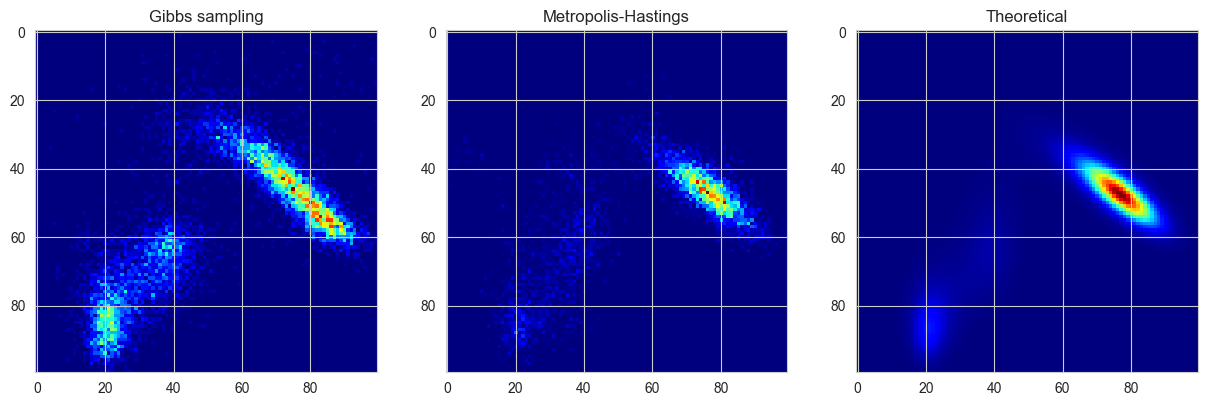

In [11]:
# Plot the prob_gibbs, prob_metropolis, and prob_theoretical as heatmaps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(prob_gibbs, cmap="jet")
ax[0].set_title("Gibbs sampling")
ax[1].imshow(prob_metropolis, cmap="jet")
ax[1].set_title("Metropolis-Hastings")
ax[2].imshow(prob_theoretical, cmap="jet")
ax[2].set_title("Theoretical")
plt.show()


In [12]:
print(kl_gibbs, kl_metropolis)

0.544925066867896 0.32425551075728576


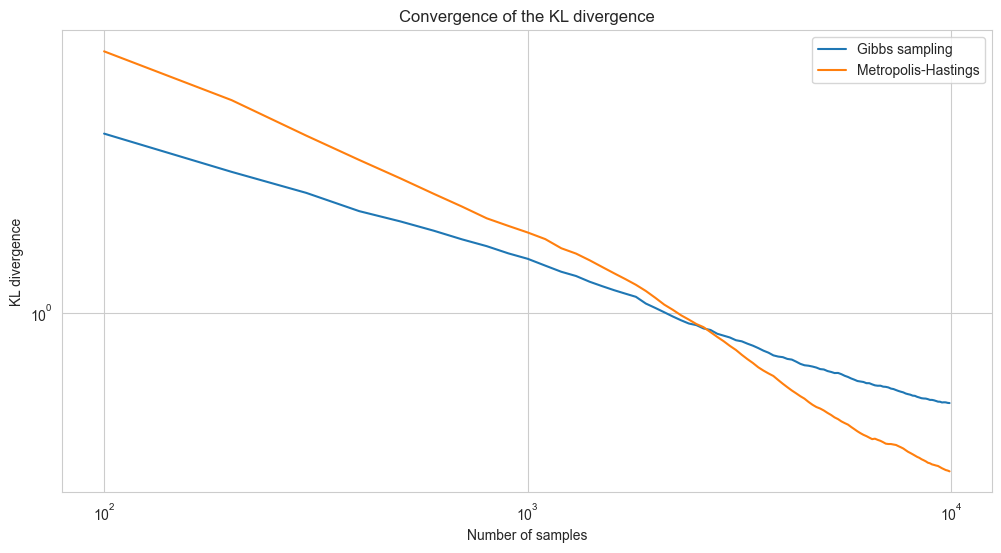

In [13]:
# Generate samples from both methods
# Perform Gibbs sampling with the Muller-Brown potential

gibbs_kls = []
metropolis_kls = []

ns = range(100, num_samples, 100)
for n in ns:
    gibbs_kls_run = []
    metropolis_kls_run = []
    for i in range(n_runs):
        gibbs_samples = gibbs_samples_all[i]
        metropolis_samples = metropolis_samples_all[i]
        
        # Create 2D histograms for the samples
        hist_gibbs, _, _ = np.histogram2d(gibbs_samples[:n, 0], gibbs_samples[:n, 1], bins=grid_size, range=[[x_min, x_max], [y_min, y_max]])
        
        hist_metropolis, _, _ = np.histogram2d(metropolis_samples[:n, 0], metropolis_samples[:n, 1], bins=grid_size, range=[[x_min, x_max], [y_min, y_max]])
        
        # Normalize to create probability distributions
        prob_gibbs = hist_gibbs / np.sum(hist_gibbs)
        prob_metropolis = hist_metropolis / np.sum(hist_metropolis)
        
        gibbs_kls_run.append(kl_divergence(prob_gibbs, prob_theoretical))
        metropolis_kls_run.append(kl_divergence(prob_metropolis, prob_theoretical))
    
    gibbs_kls.append(np.mean(gibbs_kls_run))
    metropolis_kls.append(np.mean(metropolis_kls_run))

plt.figure(figsize=(12, 6))
plt.loglog(ns, gibbs_kls, label="Gibbs sampling")
plt.loglog(ns, metropolis_kls, label="Metropolis-Hastings")
plt.legend()
plt.xlabel("Number of samples")
plt.ylabel("KL divergence")
plt.title("Convergence of the KL divergence")
plt.show()